# Initial essay text feature engineering

This notebook creates some initial features from the dataset of a Kaggle essay scoring competition and asseses their efficacy with a random forest model using the quadratic weighted cohen kappa score. A number of useful starting features are identified, including the following:

- Total words
- Average word length
- Paragraph number
- Comma to fullstop ratio
- Conjunctions count
- Conjunctive adverb count
- Academic words count
- Words per sentence
- No space after commas (a grammar mistake)

The Kaggle competition score for this notebook is 0.73

In [19]:
import pandas as pd
import numpy as np

train = pd.read_csv('data/train.csv')
train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


## Examine score

The majority of the essays score between 2 and 4, with only a slim minority scoring 1, 5, or 6.

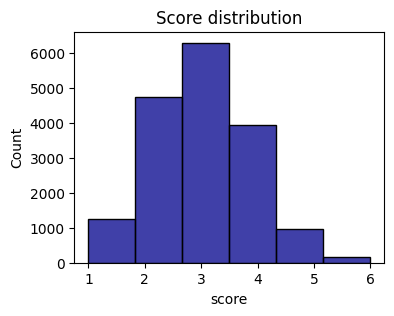

In [20]:
import matplotlib.pyplot as plt 
import seaborn as sns

# plots the level distribution
plt.figure(figsize=(4, 3));
sns.histplot(train['score'], bins=6, kde=False, color='darkblue');
plt.title('Score distribution');

## Inspect sample texts

Scanning through some of the essay texts provides hints at what possible features could be engineered.

In [22]:
sample_index = 2
print()
print(train.loc[sample_index, 'full_text'], '\n\nscore = ' + str(train.loc[sample_index, 'score']))


People always wish they had the same technology that they have seen in movies, or the best new piece of technology that is all over social media. However, nobody seems to think of the risks that these kinds of new technologies may have. Cars have been around for many decades, and now manufacturers are starting to get on the bandwagon and come up with the new and improved technology that they hope will appeal to everyone. As of right now, it seems as though the negative characteristics of these cars consume the positive idea that these manufacturers have tried to convey.

Currently, this new technology in cars has a very long way to go before being completely "driverless". Drivers still need to be on alert when they are driving, as well as control the car near any accidents or complicated traffic situations. This seems to totally defeat the purpose of the "driverless" car. Eventually the technology may improve, but nobody can be certain that the driverless car will eventually become co

## Create test features

A number of initial features are created for exploration.

In [4]:
import re
from scipy import stats

def get_feats(data):

    # total words in each essay
    data['total_words'] = [len(x.split(' ')) for x in data['full_text']]
    
    
    # average words in each sentence
    data['words_per_sentence'] = [len(x.split(' ')) / len(re.split(r'[.?!]', x)) for x in data['full_text']]  
    
    
    # average character length of each word
    def avg_word_len(i):
        return np.mean([len(word) for word in data['full_text'][i].split(' ')])
        
    data['avg_word_len'] = [avg_word_len(x) for x in range(len(data['full_text']))]
    
    
    # how often the student uses first person
    data['first_person'] = [x.lower().count(' i ') for x in data['full_text']]
    
    
    # how many times a comma is not followed by a space
    data['no_space_after_comma'] = [len(re.findall(r',\S' , x)) for x in data['full_text']]
    
    
    # how many paragraphs the text is split into
    data['paragraph_num'] = [len(x.split('\n\n')) for x in data['full_text']]
    
    
    # finds the ratio of commas to full stops
    data['comma_fullstop_ratio'] = [(x.count(',') + 0.1) / (x.count('.') + 0.1) for x in data['full_text']]
    
    
    # finds the number of times the essay mentions percentages
    data['mention_percentages'] = [x.count('%') + x.count('percent') for x in data['full_text']]
    
    
    # gets the number of conjunctions in the essay 
    conjunctions_list = ['although', 'while', 'yet', 'nor', 'either', 'not only', 'since', 'unless']
    
    def get_count(essay, list):
        return sum([x.lower() in list for x in essay.split(' ')])
    
    data['conjunctions_count'] = [get_count(x, conjunctions_list) for x in data['full_text']]
    
    
    # gets the number of conjunctive adverbs in the essay
    conjunctive_adverb_list = ['however', 'besides', 'consequently', 'also', 'moreover', 'accordingly', 
                               'furthermore', 'hence', 'nevertheless', 'otherwise', 'still', 'comparatively',
                               'conversely', 'finally', 'then', 'thus']
    
    data['conjunctive_adverb_count'] = [get_count(x, conjunctive_adverb_list) for x in data['full_text']]

    
    # gets the number of academic words
    academic_words = ['numerous', 'sparse', 'scarce', 'substantial', 'incalculable', 'abundant', 'salient', 'necessary',
                      'significant', 'increasing', 'declining', 'adequate', 'sufficient', 'indiscriminate', 'alternative',
                      'inevitable', 'particularly', 'relatively', 'perhaps', 'clearly', 'crucial', 'negative', 'extensive',
                      'demonstrate']

    data['academic_words'] = [get_count(x, academic_words) for x in data['full_text']]

    
    # gets the number of non-academic words
    non_academic_words = ['enormous', 'massive', 'huge', 'gigantic', 'colossal', 'puny', 'scrawny', 'teeny', 'tiny', 'beautiful',
                          'ugly', 'horrible', 'good', 'obviously', 'perfect', 'bad']

    data['non_academic_words'] = [get_count(x, non_academic_words) for x in data['full_text']]
    

    return data


# adds features to the dataframe
train = get_feats(train)

## Explore test feature distributions

The distributions of the newly engineered features are first examined.

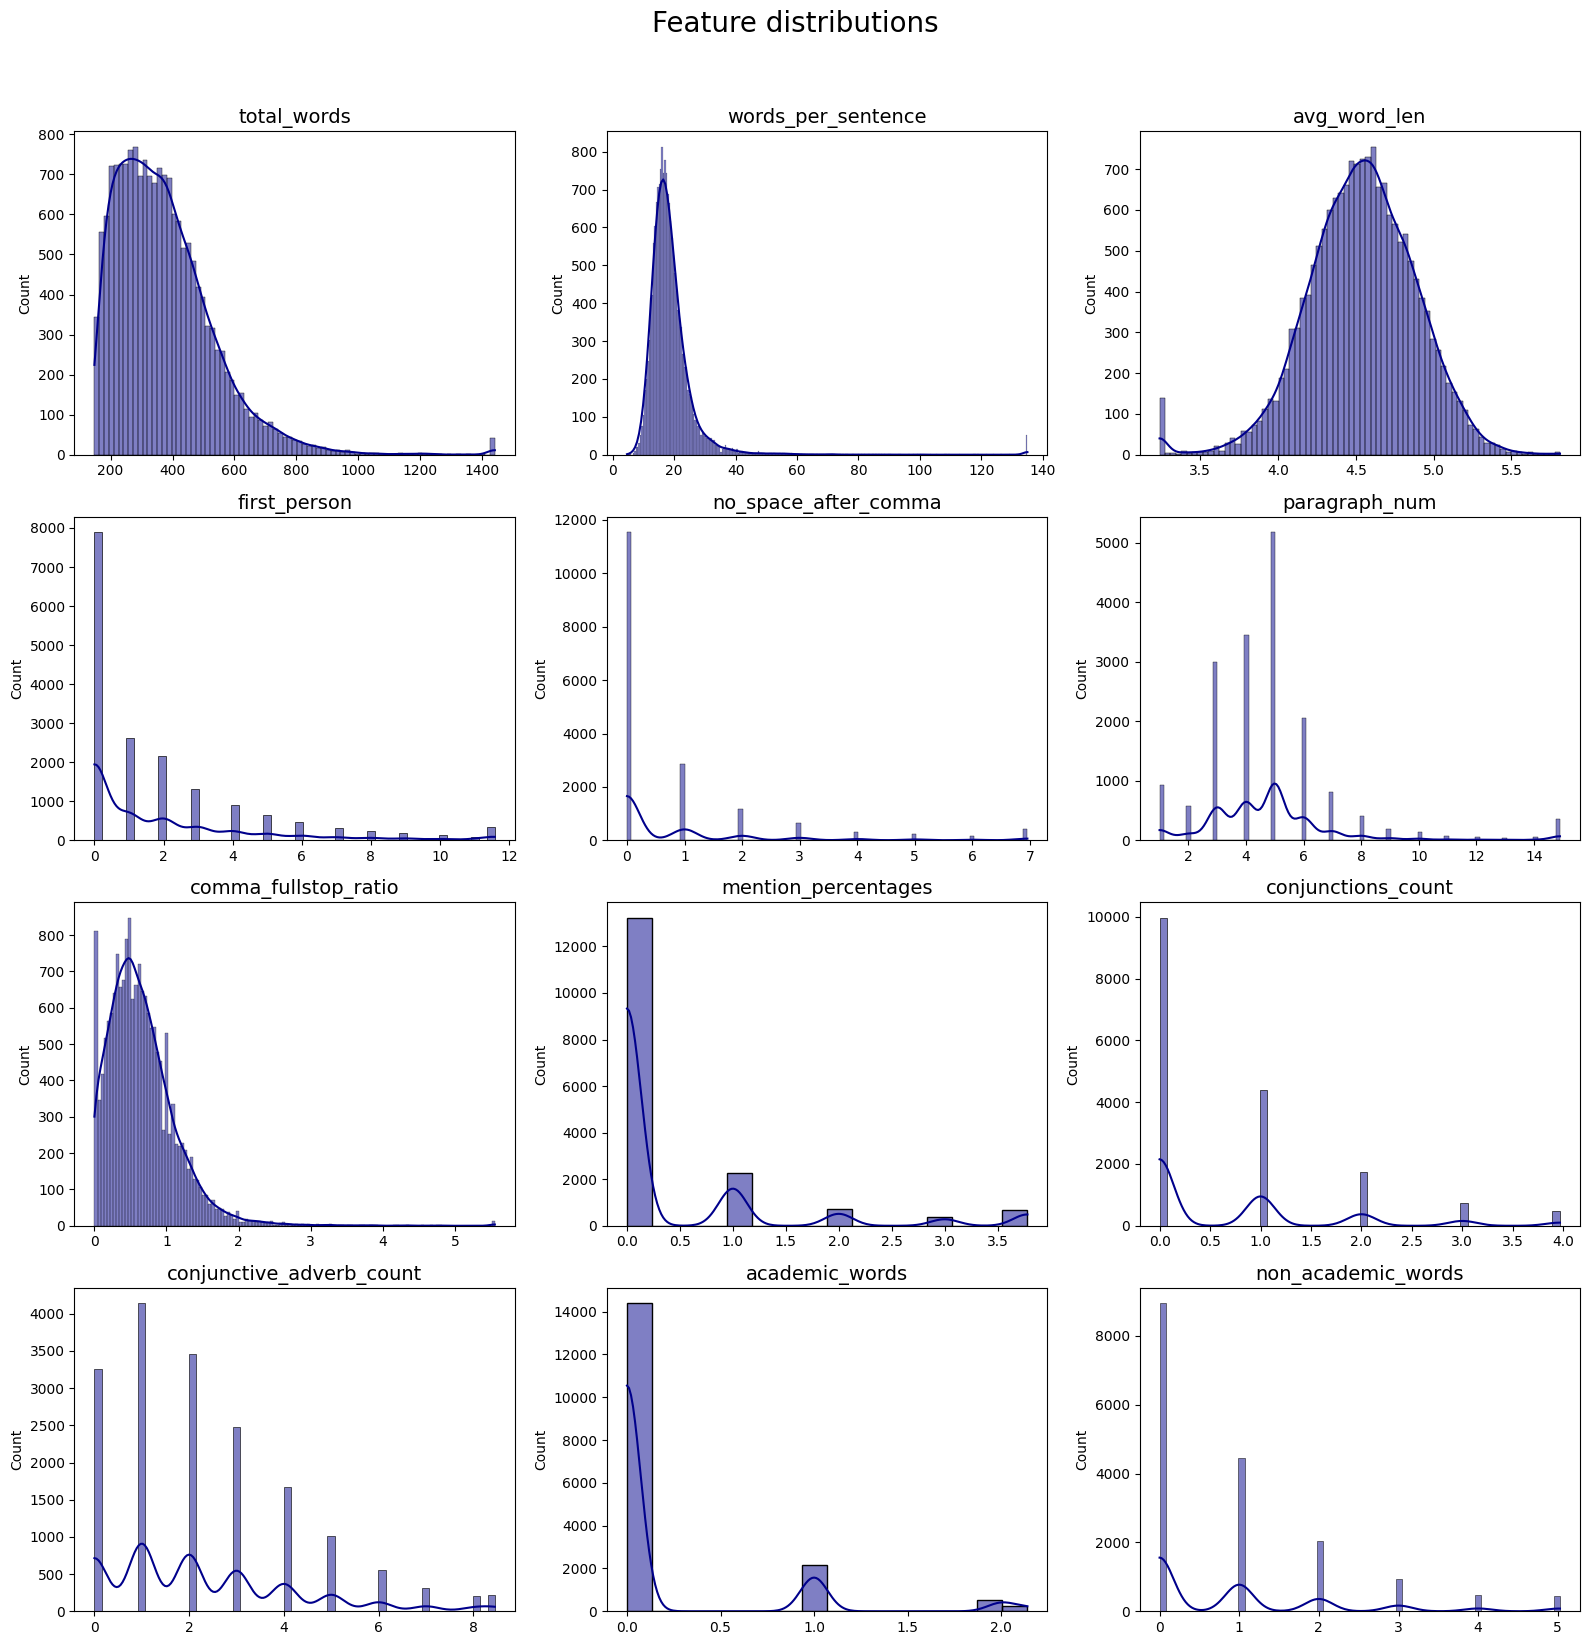

In [5]:
# plots the word length distribution
def trim(data, trim=3):
    mean, std_dev = np.mean(data), np.std(data)
    lower_bound, upper_bound = mean - trim * std_dev, mean + trim * std_dev
    trimmed_data = [x if lower_bound <= x <= upper_bound else (lower_bound if x < lower_bound else upper_bound) for x in data]
    return trimmed_data


features = ['total_words', 'words_per_sentence', 'avg_word_len', 'first_person', 'no_space_after_comma', 'paragraph_num',
           'comma_fullstop_ratio', 'mention_percentages', 'conjunctions_count', 'conjunctive_adverb_count', 'academic_words',
           'non_academic_words']


row_num = int(np.ceil(len(features) / 3))
fig, ax = plt.subplots(nrows=row_num, ncols=3, figsize=(16, 16))
ax = ax.flatten()


for i, feat in enumerate(features):
    sns.histplot(trim(train[feat]), ax=ax[i], kde=True, color='darkblue');
    ax[i].set_title(feat, size=14);


plt.suptitle('Feature distributions', fontsize=20, y=1.025);
plt.tight_layout();
plt.show();

## Check test feature correlation with score

The relationship of the features to score is then analyzed.

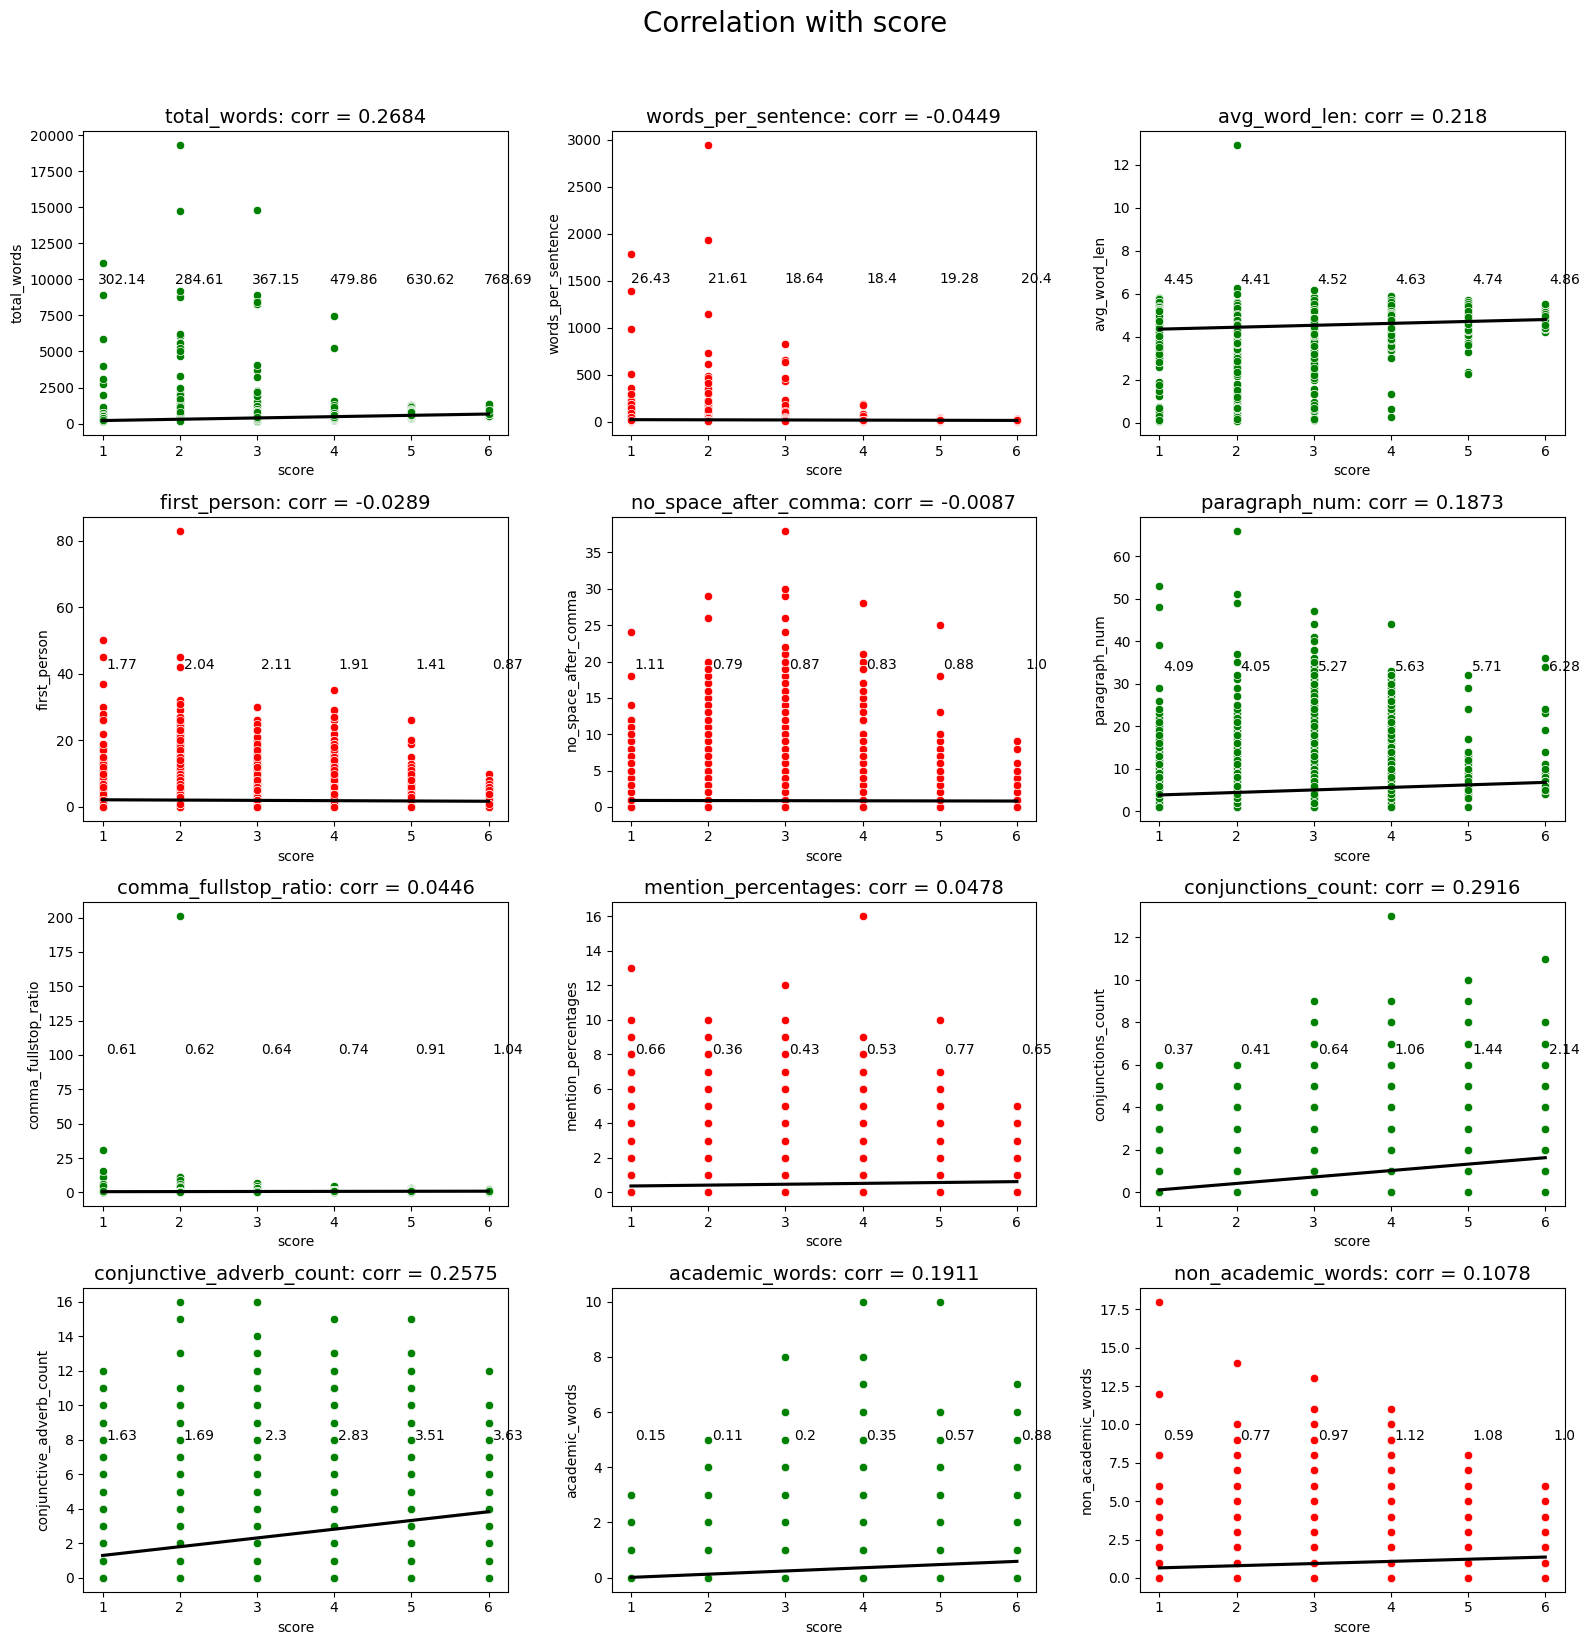

In [6]:
# returns whether a set of values largely rise or fall in a linear fashion
def linear(values):
    current = 0 
    positive = []
    negative = []
    for val in values:
        if val > current:
            positive.append(True)
            negative.append(False)
            current = val 
        else:
            positive.append(False)
            negative.append(True)
            current = val 
                
    return (sum(positive)>=5) or (sum(negative)>=4)


# defines y for use in a scatterplot below
y = train['score']


# analyses the relationship between set of features and the y variable
def correlation_analysis(data, var, title=None):

    # creates a subplot object for use below
    row_num = int(np.ceil(len(var) / 3))
    fig, ax = plt.subplots(nrows=row_num, ncols=3, figsize=(16, row_num*4))
    ax = ax.flatten()

    # loops through the variable in question 
    for i, x in enumerate(var):
    
        # calculates an average value of the feature at each score level (1-6)
        avg_x = data.groupby('score')[x].mean().reset_index().iloc[:,1]
    
        # determines the correlation of the feature to y
        corr = round(stats.pearsonr(data[x], y)[0], 4)
    
        # determines whether relationship to score is largely linear or not
        linear_trend = linear(avg_x)
    
        # changes the color based on whether it might be useful to the model or not
        if (abs(corr) >= 0.04) and (linear_trend==True):
            color = 'green'
        else:
            color = 'red'
    
        # creates a scatterplot for each feature
        sns.scatterplot(x=y, y=data[x], ax=ax[i], color=color);
        sns.regplot(x=y, y=data[x], ax=ax[i], scatter=False, color='black');
        ax[i].set_title(x + ': corr = ' + str(round(stats.pearsonr(data[x], y)[0], 4)), size=14);
        
        # adds numerical labels for average value of the feature at each score level (1-6)
        for j, tick in enumerate(avg_x):
            ax[i].text(j+1.25, max(data[x]) / 2, str(round(tick,2)), color='black', ha='center')

    if title == None:
        title = 'Correlation with score'

    plt.suptitle(title, fontsize=20, y=1.025);
    plt.tight_layout();
    plt.show();


correlation_analysis(train, features)

## Adjust and reassess poorly performing features

Poorly performing features are adjusted to see whether they might add value as a binary variable.

### Words per sentence

A binary feature indicating whether on average there are more than 36 words per sentence will be added.

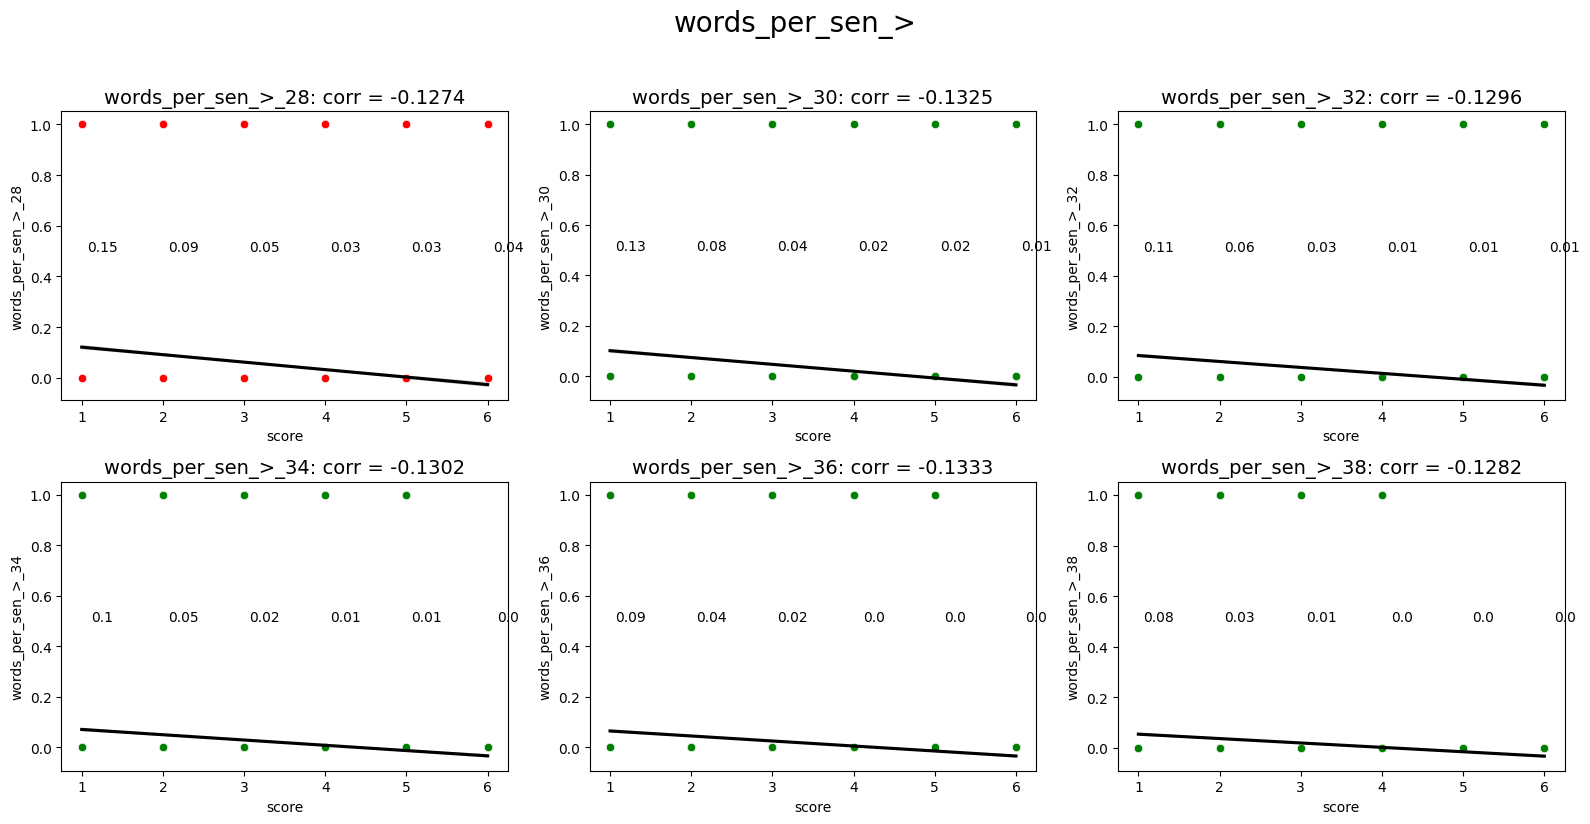

In [7]:
# sets parameter values
words_per_sen = [len(x.split(' ')) / len(re.split(r'[.?!]', x)) for x in train['full_text']]  
feature_name = 'words_per_sen_>'
cutoffs = ['28', '30', '32', '34', '36', '38']

# creates new features for different cutoff values and assesses their efficacy
def adjust_reassess(base_feature, feature_name, cutoffs):

    # loops through each variation in the feature cutoff value and creates a new binary variable to be examined
    final_feature_names = []
    for cutoff in cutoffs:
        
        final_feature_name = feature_name + '_' + cutoff
        final_feature_names.append( final_feature_name )
        
        binary_feature = list(np.where(np.array(base_feature) > eval(cutoff), 1, 0))
        train[final_feature_name] = binary_feature
    
    # checks the correlation
    correlation_analysis(train, final_feature_names, title=feature_name)

adjust_reassess(base_feature=words_per_sen, feature_name=feature_name, cutoffs=cutoffs)

### First person

No feature will be added for the use of first person. 

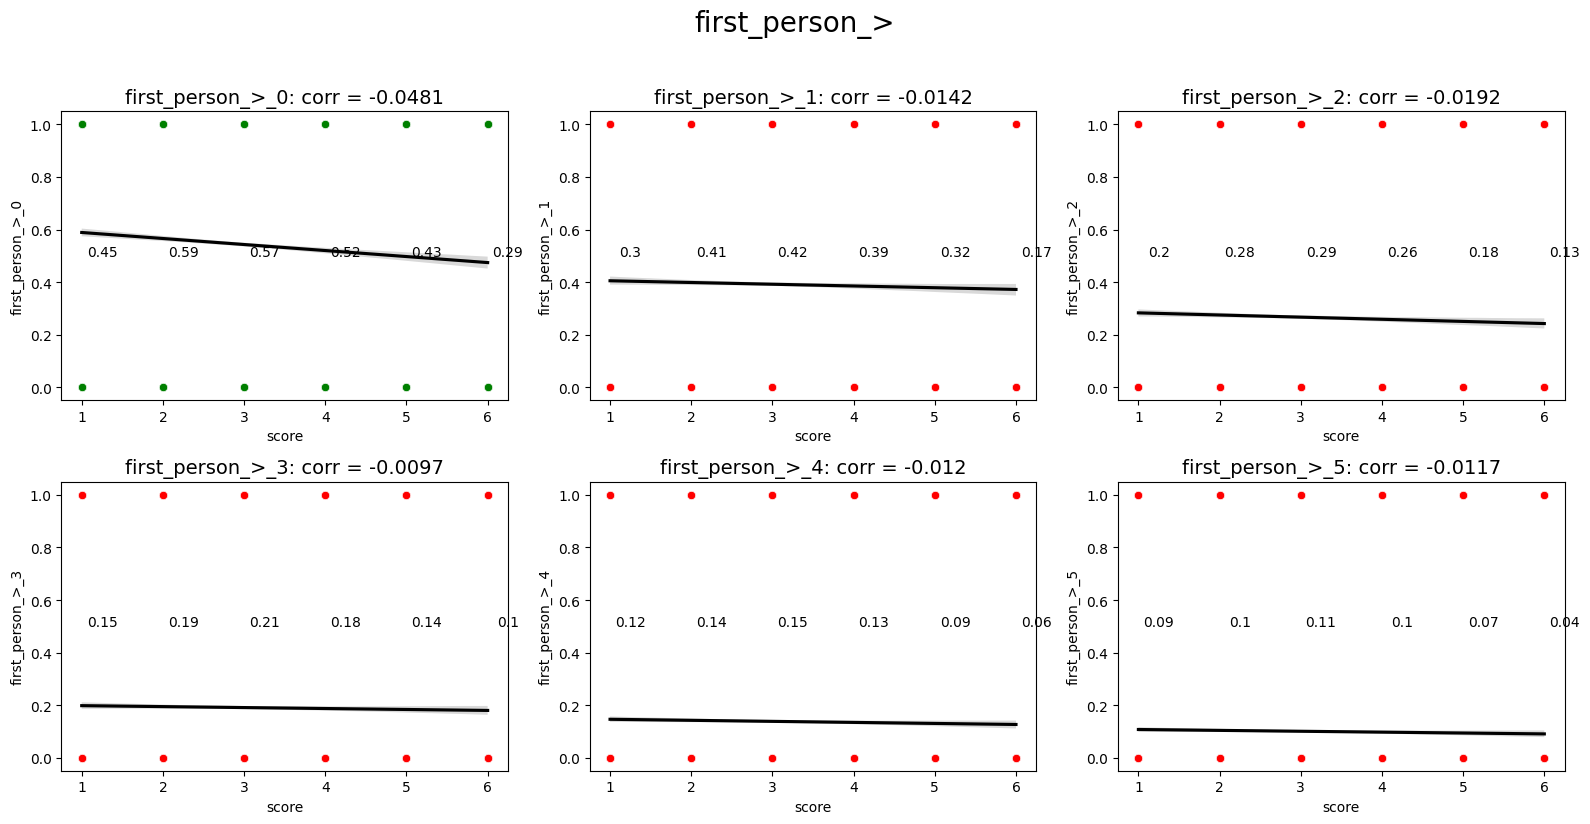

In [8]:
# sets parameter values
first_person = [x.lower().count(' i ') for x in train['full_text']]
feature_name = 'first_person_>'
cutoffs = ['0', '1', '2', '3', '4', '5']

# checks the correlations
adjust_reassess(base_feature=first_person, feature_name=feature_name, cutoffs=cutoffs)

### No space after comma

A binary feature indicating whether on average there are more than 4 instances of a comma not followed by a space (a grammar mistake) will be added.

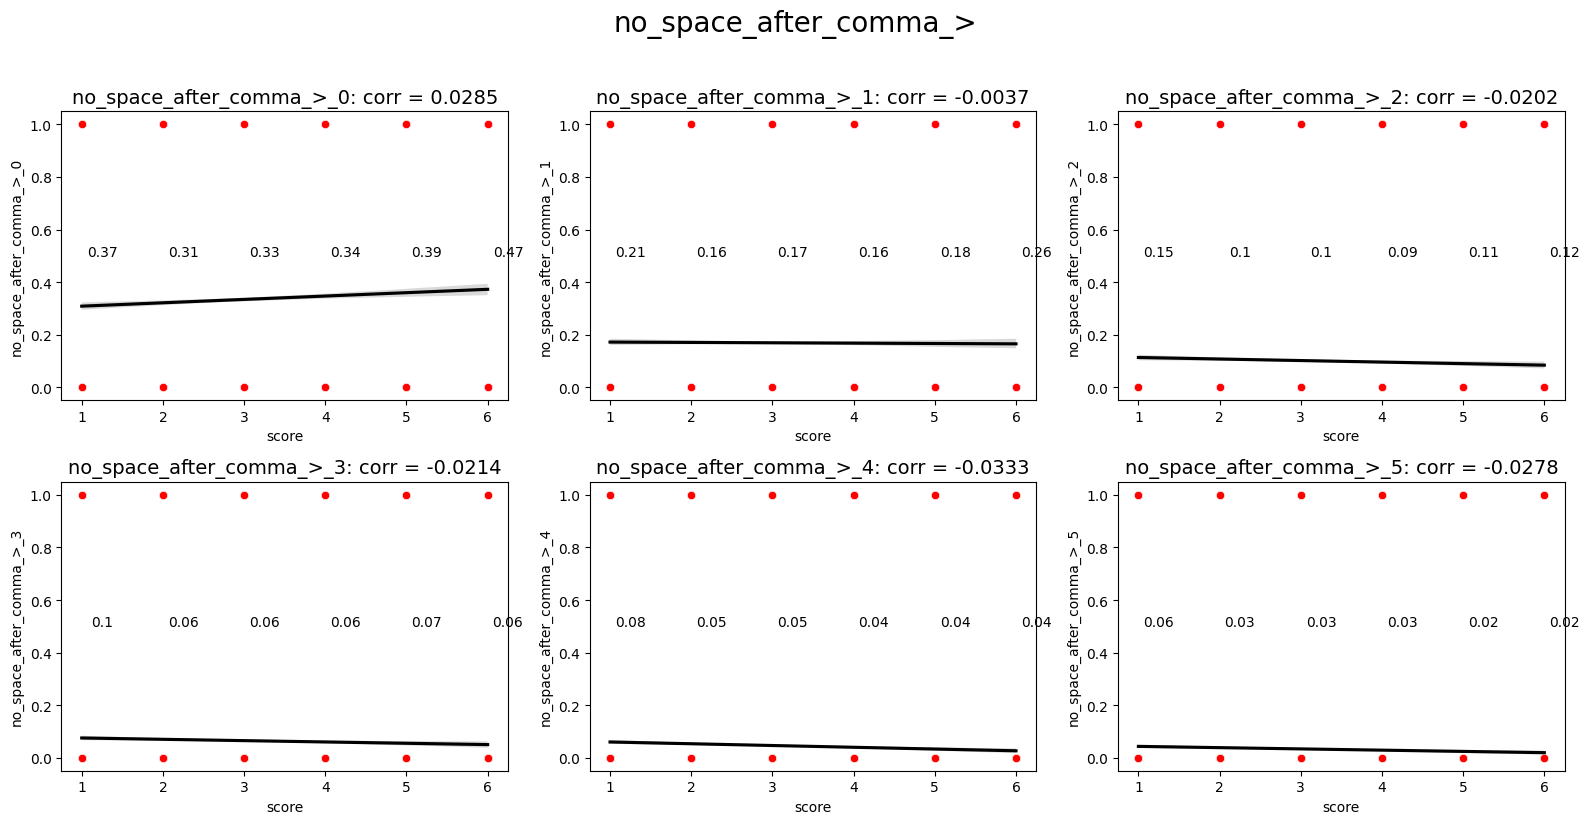

In [9]:
# sets parameter values
no_space_after_comma = [len(re.findall(r',\S' , x)) for x in train['full_text']]
feature_name = 'no_space_after_comma_>'
cutoffs = ['0', '1', '2', '3', '4', '5']

# checks the correlations
adjust_reassess(base_feature=no_space_after_comma, feature_name=feature_name, cutoffs=cutoffs)

### Comma to fullstop ratio

Although this binary feature looks strong, it is not added as it doesn't seem to imporve the result vis a vis itself as a continuous feature.  

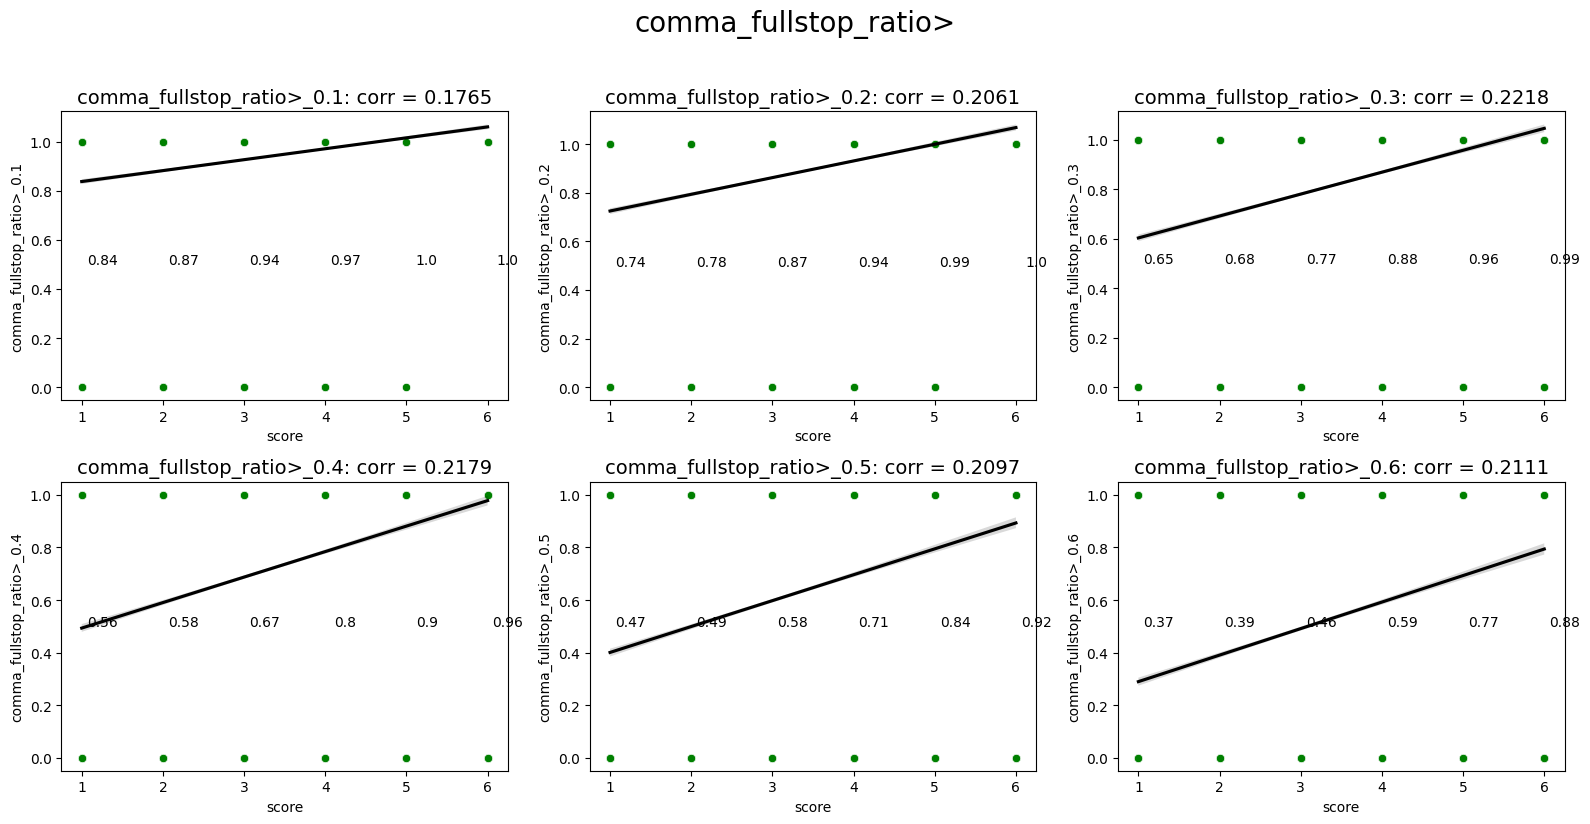

In [10]:
# sets parameter values
comma_fullstop_ratio = [(x.count(',') + 0.1) / (x.count('.') + 0.1) for x in train['full_text']]
feature_name = 'comma_fullstop_ratio>'
cutoffs = ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6']

# checks the correlations
adjust_reassess(base_feature=comma_fullstop_ratio, feature_name=feature_name, cutoffs=cutoffs)

### Mentions percentages

No feature will be added for the mention of percentages.

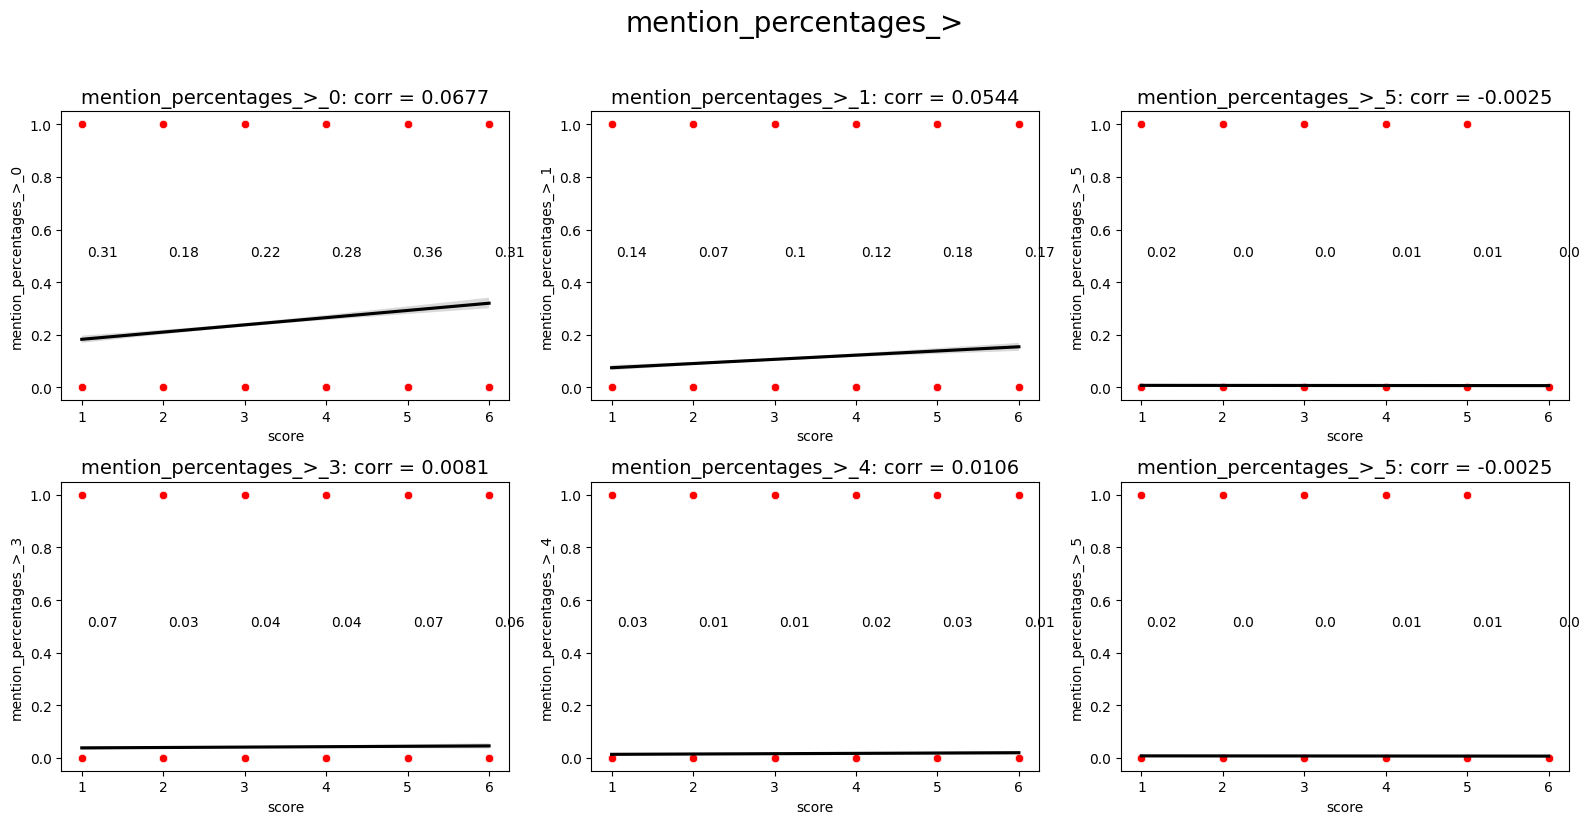

In [11]:
# sets parameter values
mention_percentages = [x.count('%') + x.count('percent') for x in train['full_text']]
feature_name = 'mention_percentages_>'
cutoffs = ['0', '1', '5', '3', '4', '5']

# checks the correlations
adjust_reassess(base_feature=mention_percentages, feature_name=feature_name, cutoffs=cutoffs)

### Non-acadmemic words

Although this binary feature looks like it could add value, it is not added as it doesn't seem to imporve the results on the competition test set.

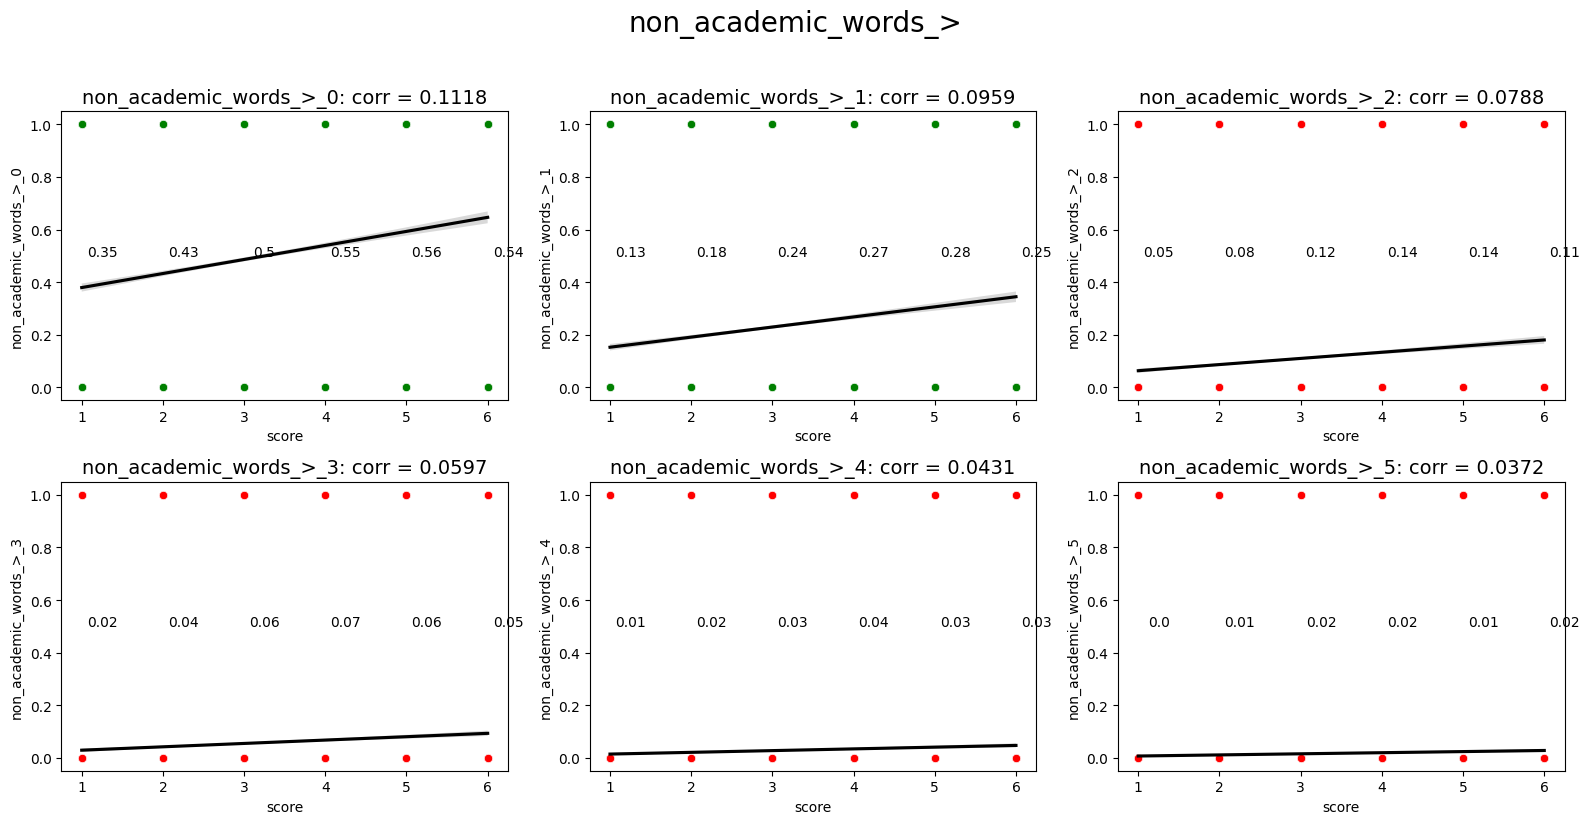

In [12]:
# sets parameter values
def get_count(essay, list):
        return sum([x.lower() in list for x in essay.split(' ')])
    
non_academic_words_list = ['enormous', 'massive', 'huge', 'gigantic', 'colossal', 'puny', 'scrawny', 'teeny', 'tiny', 'beautiful',
                          'ugly', 'horrible', 'good', 'obviously', 'perfect', 'bad']

non_academic_words = [get_count(x, non_academic_words_list) for x in train['full_text']]
feature_name = 'non_academic_words_>'
cutoffs = ['0', '1', '2', '3', '4', '5']

# checks the correlations
adjust_reassess(base_feature=non_academic_words, feature_name=feature_name, cutoffs=cutoffs)

## Final feature selection

The final features are selected for modeling.  

In [13]:
# transforms a dataframe into the desired features
def preprocess(data):
    
    # total words in each essay
    data['total_words'] = [len(x.split(' ')) for x in data['full_text']]


    # average character length of each word
    def avg_word_len(i):
        return np.mean([len(word) for word in data['full_text'][i].split(' ')])
        
    data['avg_word_len'] = [avg_word_len(x) for x in range(len(data['full_text']))]


    # how many paragraphs the text is split into
    data['paragraph_num'] = [len(x.split('\n\n')) for x in data['full_text']]


    # finds the ratio of commas to full stops
    data['comma_fullstop_ratio'] = [(x.count(',') + 0.1) / (x.count('.') + 0.1) for x in data['full_text']]


     # gets the number of conjunctions in the essay 
    conjunctions_list = ['although', 'while', 'yet', 'nor', 'either', 'not only', 'since', 'unless']
    
    def get_count(essay, list):
        return sum([x.lower() in list for x in essay.split(' ')])
    
    data['conjunctions_count'] = [get_count(x, conjunctions_list) for x in data['full_text']]
    
    
    # gets the number of conjunctive adverbs in the essay
    conjunctive_adverb_list = ['however', 'besides', 'consequently', 'also', 'moreover', 'accordingly', 
                               'furthermore', 'hence', 'nevertheless', 'otherwise', 'still', 'comparatively',
                               'conversely', 'finally', 'then', 'thus']
    
    data['conjunctive_adverb_count'] = [get_count(x, conjunctive_adverb_list) for x in data['full_text']]
    

    # gets the number of academic words
    academic_words = ['numerous', 'sparse', 'scarce', 'substantial', 'incalculable', 'abundant', 'salient', 'necessary',
                      'significant', 'increasing', 'declining', 'adequate', 'sufficient', 'indiscriminate', 'alternative',
                      'inevitable', 'particularly', 'relatively', 'perhaps', 'clearly', 'crucial', 'negative', 'extensive',
                      'demonstrate']

    data['academic_words'] = [get_count(x, academic_words) for x in data['full_text']]


    # average words per sentence over 36
    words_per_sen = [len(x.split(' ')) / len(re.split(r'[.?!]', x)) for x in data['full_text']]  
    data['words_per_sen_>_36'] = list(np.where(np.array(words_per_sen) > 36, 1, 0))


    # no space after comma instances over 4
    no_space_after_comma = [len(re.findall(r',\S' , x)) for x in data['full_text']]
    data['no_space_after_comma_>_4'] = list(np.where(np.array(no_space_after_comma) > 4, 1, 0))


    # mention of academic words or not
    non_academic_words_list = ['enormous', 'massive', 'huge', 'gigantic', 'colossal', 'puny', 'scrawny', 'teeny', 'tiny', 'beautiful',
                          'ugly', 'horrible', 'good', 'obviously', 'perfect', 'bad']

    non_academic_words = [get_count(x, non_academic_words_list) for x in data['full_text']]
    data['non_academic_words_>_0'] = list(np.where(np.array(non_academic_words) > 0, 1, 0))


    # drop uneeded columns 
    data.drop(['essay_id', 'full_text'], inplace=True, axis=1)


    return data


# imports the train set again
train = pd.read_csv('data/train.csv')

# retrieves selected features
train = preprocess(train)

## Fit a model

A model is then fit on the data. No random seed is used to get a feel for the variability in the data.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# creates x and y variables
x = train.drop(columns=['score'])
y = train['score']

# splits the data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

# fits the data on a random forest model
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train,y_train)

RandomForestClassifier()

## Evaluate performance

In [17]:
from sklearn.metrics import cohen_kappa_score

preds = model.predict(x_val)
cohen_kappa = cohen_kappa_score(preds, y_val, weights='quadratic')

print()
print('Cohen Kappa Score: ' + str( round(cohen_kappa, 2) ))


Cohen Kappa Score: 0.67
